In [1]:
import re
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy import stats
from collections import Counter
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

In [2]:
warnings.filterwarnings("ignore")

In [3]:
plt.rcParams['figure.figsize'] = (12,6)

In [4]:
data = pd.read_excel("/content/combined (1).xlsx")

In [5]:
data.head()

,time(UTC),T2m,RH,G(h),Gb(n),Gd(h),IR(h),WS10m,WD10m,SP,state
0,20150121:0700,19.78,47.65,693.0,861.38,138.0,297.80,1.17,158,90845,arunachal pradesh
1,20150116:0600,18.66,43.25,716.0,901.63,125.0,317.80,1.10,6,90712,arunachal pradesh
2,20150201:1200,18.00,60.40,89.0,301.51,48.0,318.60,1.66,96,98809,punjab
3,20151007:0500,27.58,88.55,606.0,220.19,419.0,438.05,0.21,149,99530,tripura
4,20151007:1100,33.38,37.55,247.0,404.76,120.0,409.05,1.59,334,99158,uttar pradesh


In [6]:
df = data.copy()

In [7]:
month = []
year = []
day = []
hour = []
for y in range(0,len(df)):
    x = df['time(UTC)'][y]
    year.append(x[:4])
    month.append(x[4:6])
    day.append(x[6:8])
    hour.append(x[9:11])
df['year'] = year
df['month'] = month
df['day'] = day
df['hour'] = hour

In [8]:
df.head()

,time(UTC),T2m,RH,G(h),Gb(n),Gd(h),IR(h),WS10m,WD10m,SP,state,year,month,day,hour
0,20150121:0700,19.78,47.65,693.0,861.38,138.0,297.80,1.17,158,90845,arunachal pradesh,2015,01,21,07
1,20150116:0600,18.66,43.25,716.0,901.63,125.0,317.80,1.10,6,90712,arunachal pradesh,2015,01,16,06
2,20150201:1200,18.00,60.40,89.0,301.51,48.0,318.60,1.66,96,98809,punjab,2015,02,01,12
3,20151007:0500,27.58,88.55,606.0,220.19,419.0,438.05,0.21,149,99530,tripura,2015,10,07,05
4,20151007:1100,33.38,37.55,247.0,404.76,120.0,409.05,1.59,334,99158,uttar pradesh,2015,10,07,11


In [9]:
df.drop(['time(UTC)', 'Gb(n)', 'Gd(h)', 'IR(h)'], axis = 1, inplace = True)

In [10]:
np.array(df['G(h)'])

array([693.  , 716.  ,  89.  , ..., 176.  , 681.  , 723.35])

In [ ]:
#df.columns.values[0:11] =["Temp", "Humidity", "Radiation", "WindSpeed", "WindDirection", "AirPressure","State","Year","Month","Day","Hour"]

In [11]:
df.head()

,T2m,RH,G(h),WS10m,WD10m,SP,state,year,month,day,hour
0,19.78,47.65,693.0,1.17,158,90845,arunachal pradesh,2015,01,21,07
1,18.66,43.25,716.0,1.10,6,90712,arunachal pradesh,2015,01,16,06
2,18.00,60.40,89.0,1.66,96,98809,punjab,2015,02,01,12
3,27.58,88.55,606.0,0.21,149,99530,tripura,2015,10,07,05
4,33.38,37.55,247.0,1.59,334,99158,uttar pradesh,2015,10,07,11


In [12]:
input_features = df.drop('G(h)', axis = 1)
target = df['G(h)']

In [13]:
df.corr()

,T2m,RH,G(h),WS10m,WD10m,SP
T2m,1.000000,-0.468821,0.281205,0.303412,0.028752,0.468078
RH,-0.468821,1.000000,-0.404068,-0.347295,-0.015822,-0.191620
G(h),0.281205,-0.404068,1.000000,0.091232,0.055541,-0.061601
WS10m,0.303412,-0.347295,0.091232,1.000000,0.063282,0.322677
WD10m,0.028752,-0.015822,0.055541,0.063282,1.000000,-0.070542
SP,0.468078,-0.191620,-0.061601,0.322677,-0.070542,1.000000


In [14]:
target

0       693.00
1       716.00
2        89.00
3       606.00
4       247.00
         ...  
5481    864.00
5482    500.00
5483    176.00
5484    681.00
5485    723.35
Name: G(h), Length: 5486, dtype: float64

In [15]:
label_encoder = LabelEncoder()
train_Y = label_encoder.fit_transform(target)
input_features['state'] = label_encoder.fit_transform(input_features['state'])

In [16]:
input_features.head()

,T2m,RH,WS10m,WD10m,SP,state,year,month,day,hour
0,19.78,47.65,1.17,158,90845,1,2015,01,21,07
1,18.66,43.25,1.10,6,90712,1,2015,01,16,06
2,18.00,60.40,1.66,96,98809,20,2015,02,01,12
3,27.58,88.55,0.21,149,99530,24,2015,10,07,05
4,33.38,37.55,1.59,334,99158,25,2015,10,07,11


In [17]:
target_cont = df['G(h)'].apply(lambda x : int(x*100))

In [18]:
scaled_input_features = MinMaxScaler().fit_transform(input_features)

In [19]:
bestfeatures = SelectKBest(score_func = chi2, k = 10)
fit = bestfeatures.fit(scaled_input_features, target_cont)

In [20]:
scores = pd.DataFrame(fit.scores_)
column = pd.DataFrame(input_features.columns)

In [21]:
featureScores = pd.concat([column, scores], axis=1)

#naming the dataframe columns
featureScores.columns = ['Features', 'feature_imp'] 

In [22]:
featureScores.sort_values(by = 'feature_imp', ascending=False, inplace=True)
featureScores

,Features,feature_imp
7,month,403.113785
1,RH,247.040854
5,state,230.674778
3,WD10m,207.176344
8,day,206.839842
9,hour,170.757677
4,SP,162.501022
2,WS10m,131.042749
0,T2m,126.064798
6,year,43.701900


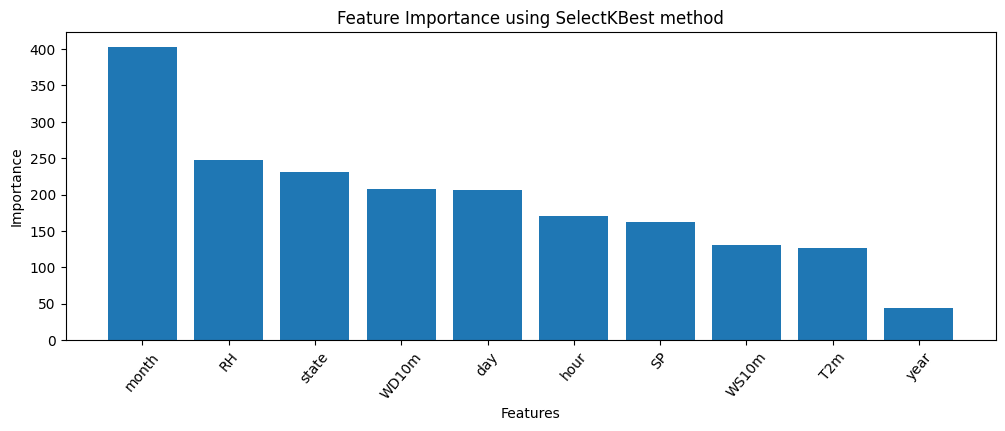

In [23]:
plt.figure(figsize = (12, 4))
plt.bar(featureScores.Features, featureScores.feature_imp)
plt.xticks(rotation = 50)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance using SelectKBest method")
plt.show()

In [24]:
xtrain, xtesta, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

In [25]:
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtesta)
xtrain.shape, xtest.shape

((4388, 10), (1098, 10))

In [26]:
params = {
    'learning_rate': 0.1,
    'max_depth': 8}
model = XGBRegressor(**params)
model.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [27]:
y_pred = model.predict(xtest)

In [28]:
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
r2 = r2_score(ytest, y_pred)

print("Testing performance ~")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance ~
RMSE: 90.50
R2: 0.88


In [29]:
model = None
model = Sequential()
    
model.add(Dense(128, activation='relu', input_dim=10))
model.add(Dropout(0.33))
    
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1, activation='linear'))
    
model.compile(metrics='mse', loss='mae', optimizer=Adam(learning_rate=0.001))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                1

In [30]:
history = model.fit(xtrain, ytrain, validation_split=0.1, epochs=30, batch_size=32)

Epoch 1/30
124/124 [==============================] - 3s 6ms/step - loss: 372.9019 - mse: 204584.4844 - val_loss: 205.3741 - val_mse: 60096.9805
Epoch 2/30
124/124 [==============================] - 0s 3ms/step - loss: 233.7707 - mse: 82365.5938 - val_loss: 187.2946 - val_mse: 51417.2070
Epoch 3/30
124/124 [==============================] - 0s 3ms/step - loss: 217.1520 - mse: 72309.9844 - val_loss: 183.6185 - val_mse: 49610.3867
Epoch 4/30
124/124 [==============================] - 0s 4ms/step - loss: 215.5149 - mse: 70217.1719 - val_loss: 177.5550 - val_mse: 46754.7031
Epoch 5/30
124/124 [==============================] - 0s 4ms/step - loss: 211.1350 - mse: 67970.2812 - val_loss: 169.8182 - val_mse: 42672.0742
Epoch 6/30
124/124 [==============================] - 0s 3ms/step - loss: 205.9837 - mse: 64723.3125 - val_loss: 164.2964 - val_mse: 40160.4648
Epoch 7/30
124/124 [==============================] - 0s 3ms/step - loss: 205.4540 - mse: 65075.4961 - val_loss: 158.7269 - val_mse: 37

In [31]:
y_pred = model.predict(xtest)

35/35 [==============================] - 0s 3ms/step


In [32]:
xy = pd.DataFrame(xtesta)

In [33]:
scores = model.evaluate(xtest, ytest)
mae = scores[0]
mse = scores[1]

35/35 [==============================] - 0s 2ms/step - loss: 95.7025 - mse: 15260.0625


In [34]:
print('Mean absolute error: ', mae)
print('Mean squared error: ', mse)

Mean absolute error:  95.7025146484375
Mean squared error:  15260.0625


In [35]:
r2_score(ytest,y_pred)

0.7856388216884735

In [78]:
df2 = pd.read_excel("/content/state_test.xlsx")

In [79]:
df3 = df2.copy()

In [80]:
df2 = scaler.transform(df2)

In [81]:
y_preda = model.predict(df2)

1/1 [==============================] - 0s 24ms/step


In [82]:
df3.head()

,T2m,RH,WS10m,WD10m,SP,state,year,month,day,hour
0,30.71,36.15,2.83,55,95423,0,2015,11,12,9
1,19.78,47.65,1.17,158,90845,1,2015,1,21,7
2,27.78,75.60,0.55,280,91791,2,2015,5,11,6
3,22.59,51.20,0.48,260,100999,3,2015,1,6,11
4,28.21,48.60,2.62,59,98252,4,2015,11,10,5


In [83]:
df3['state'] = label_encoder.inverse_transform(df3['state'])

In [104]:
for i in range(0, len(y_preda)):
  print(df3['T2m'][i],df3['RH'][i],df3['WS10m'][i],df3['WD10m'][i],df3['SP'][i],df3['state'][i],df3['year'][i],df3['month'][i],df3['day'][i],df3['hour'][i],y_preda[i])

30.71 36.15 2.83 55 95423 andhra pradesh 2015 11 12 9 [592.17474]
19.78 47.65 1.17 158 90845 arunachal pradesh 2015 1 21 7 [572.1053]
27.78 75.6 0.55 280 91791 assam 2015 5 11 6 [690.9753]
22.59 51.2 0.48 260 100999 bihar 2015 1 6 11 [188.57304]
28.21 48.6 2.62 59 98252 chhattisgarh 2015 11 10 5 [608.9184]
10.79 92.5 1.59 305 98969 delhi 2015 3 12 2 [94.3893]
28.29 45.2 0.76 343 100251 goa 2015 1 8 5 [782.25104]
29.47 22.95 2.9 60 100685 gujarat 2015 2 4 9 [591.93726]
19.54 87.6 1.52 113 98861 haryana 2015 4 13 1 [89.574875]
16.18 43.0 1.1 252 78671 himachal pradesh 2015 5 10 9 [714.7836]
29.63 66.8 2.76 282 95207 jharkhand 2015 8 7 7 [611.60785]
23.45 50.75 3.45 109 95366 karnataka 2016 1 8 4 [362.50018]
24.79 65.4 1.31 57 99657 kerala 2016 2 17 3 [271.8112]


In [40]:
xtesta['state'] = label_encoder.inverse_transform(xtesta['state'])

In [ ]:
#plt.plot(xtesta['state'], y_preda)
#plt.bar(xtesta['state'], y_pred, color ='maroon', width = 0.4)

In [71]:
xtesta.head()

,T2m,RH,WS10m,WD10m,SP,state,year,month,day,hour
1385,29.33,69.25,1.72,51,99925,tamil nadu,2015,11,07,06
4932,29.49,50.25,1.72,47,95414,andhra pradesh,2015,11,06,07
694,23.82,44.05,3.79,164,94419,maharashtra,2015,02,11,04
5296,20.88,66.40,1.31,225,101338,bihar,2016,01,08,04
4737,32.05,35.75,2.28,33,101219,west bengal,2015,03,16,08


In [63]:
input_features.head(60)

,T2m,RH,WS10m,WD10m,SP,state,year,month,day,hour
0,19.78,47.65,1.17,158,90845,1,2015,01,21,07
1,18.66,43.25,1.10,6,90712,1,2015,01,16,06
2,18.00,60.40,1.66,96,98809,20,2015,02,01,12
3,27.58,88.55,0.21,149,99530,24,2015,10,07,05
4,33.38,37.55,1.59,334,99158,25,2015,10,07,11
5,32.56,52.80,2.00,325,99404,25,2015,10,01,12
6,10.84,97.45,0.41,169,80739,22,2015,10,19,05
7,26.82,57.84,2.22,169,101140,27,2015,03,01,05
8,26.56,53.05,1.72,314,100910,27,2015,03,04,07
9,33.77,52.25,1.79,152,95655,19,2015,05,18,11
